# Basic tutorial: ``Interleaving`` class

This class encodes all the information needed to figureout an interleaving between two ``MapperGraph`` instances. 


In [1]:
from cereeberus import ReebGraph, MapperGraph, Interleave
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt

We have two example Mapper graphs to work with. 

Text(0.5, 1.0, 'M_1')

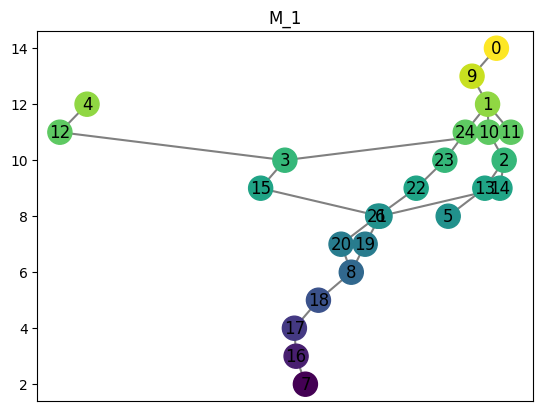

In [2]:
M1 = ex_mg.interleave_example_A()
M1.draw()
plt.title('M_1')

Text(0.5, 1.0, 'M_2')

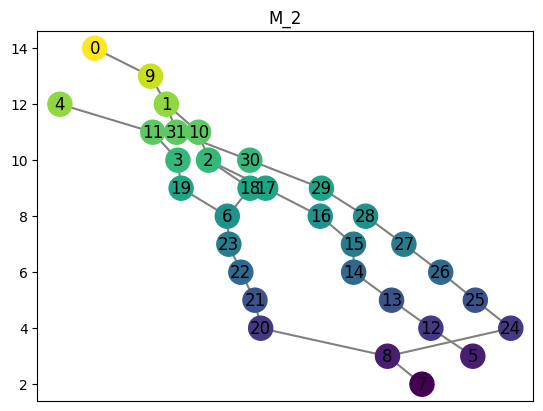

In [3]:
M2 = ex_mg.interleave_example_B()
M2.draw()
plt.title('M_2')

We can create an instance of the interleaving class to store all the relevant matrices and smoothed graphs. 

In [4]:
myInt = Interleave(M1, M2)

ValueError: 0 is not in list

Inside of the  `Interleave` class, we have lots of setup data ready to go. 

Internally, the two graphs are labeled as $F$ and $G$, and an interleaving itself is a pair of maps $\phi:F \to G^n$ and $\psi: G \to F^n$. 

First we have the two original graphs stored as follows. The $F$ graphs for $0$, $n$, and $2n$ are in a dictionary `myInt.F` with keys `['0','n','2n']`. (Note the `0` is a string, not an integer).

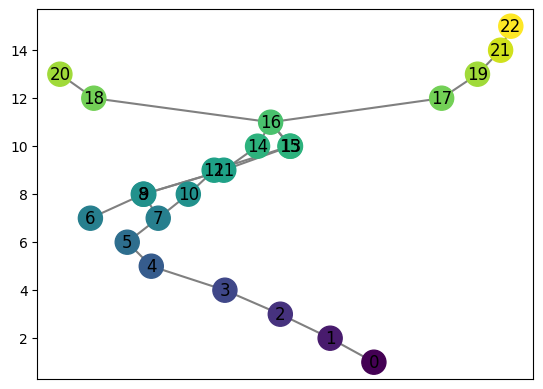

In [ ]:
myInt.F('n').draw()

In [ ]:
for key in ['0', 'n', '2n']:
    print(f"F_{key}: {myInt.F(key).summary()}")

F_0: {'nodes': 25, 'edges': 26}
F_n: {'nodes': 23, 'edges': 24}
F_2n: {'nodes': 22, 'edges': 22}


Similarly, we have a dictionary of the $G$ graphs. 

In [ ]:
for key in ['0', 'n', '2n']:
    print(f"G_{key}: {myInt.G(key).summary()}")

G_0: {'nodes': 32, 'edges': 32}
G_n: {'nodes': 32, 'edges': 32}
G_2n: {'nodes': 32, 'edges': 32}


## Matrices 

There are many matrices stored in the `Interleave` class, but since these are largely block matrices due to the function preserving restriction on the maps, we store these in the following structure. 

A block dictionary is a dictionary with keys as the integer function values for the relevant graphs. Each key $i$ maps to another dictionary with keys
- `array`: the matrix for the $i$ th block
- `rows`: A list of the vertices (or edges) in order represented in the rows of the matrix
- `cols`: A list of the vertices (or edges) in order represented in the rows of the matrix. 

### Matrices for Maps Induced by Inclusion
The first block matrices are the inclusion matrices, which can be accessed by calling `Interleave.I`. These matrices give the maps $F \to F_n \to F_{2n}$ and $G \to G_n \to G_{2n}$. 

In [ ]:
# For example, the induced inclusion map from $G$ to $G_{n}$ for the vertices is given by:
myInt.I('G','n','V')

# The block of the diagram sending vertices with function value 7 in $V(F_n)$ to vertices with value 7 in $V(F_{2n})$ is given by:
myInt.I('F','n','V')[7]

LabeledMatrix(
array=
[[0. 1.]
 [1. 0.]], 
rows=[8, 9], 
cols=[6, 7])

Reading the output above, we see that vertex 6 in $F_n$ is sent to vertex $9$ in $F_{2n}$, while vertex 7 in $F_n$ is sent to vertex $8$ in $F_{2n}$

Each map is stored as a `LabeledBlockMatrix` type. The full matrix with all the blocks in place can be accessed as follows. 

In [ ]:
myInt.I('F','n','V').to_labeled_matrix()

LabeledMatrix(
array=
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1

And for visualizing, we can use the draw function to plot the matrix with rows and columns labeled accordingly. 

Text(0.5, 1.0, 'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Vertices')

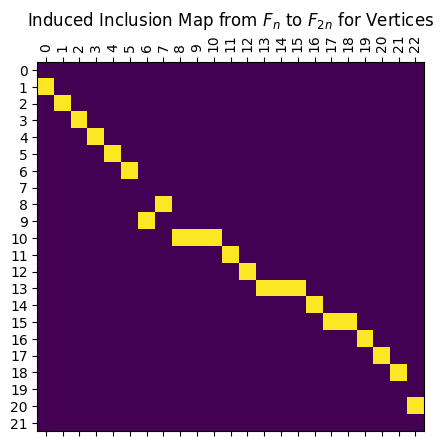

In [ ]:
myInt.I('F','n','V').draw()
plt.title(r'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Vertices')

We also have the induced maps for edges. This can be found as follows, or the full matrix can be drawn directly using the `draw_I` command. Note that the third entry for edge labels comes from the `nx.MultiDiGraph` parent class. 

LabeledMatrix(
array=
[[1. 1. 0.]
 [0. 0. 1.]], 
rows=[(10, 11, 0), (10, 12, 0)], 
cols=[(8, 11, 0), (9, 11, 0), (10, 12, 0)])


Text(0.5, 1.0, 'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Edges with Function Value 8')

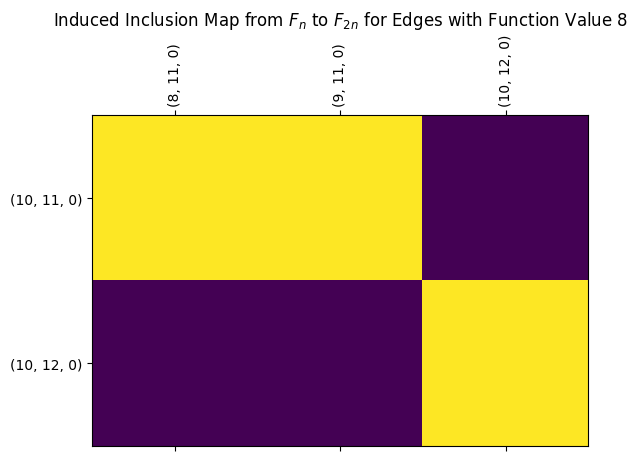

In [ ]:
print(myInt.I('F','n','E')[8])

myInt.I('F','n','E')[8].draw()
plt.title(r'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Edges with Function Value 8')

There are also commands to draw individual $I$ maps using `Interleave.drawI`. The command below draws all of these at once for convenience. 

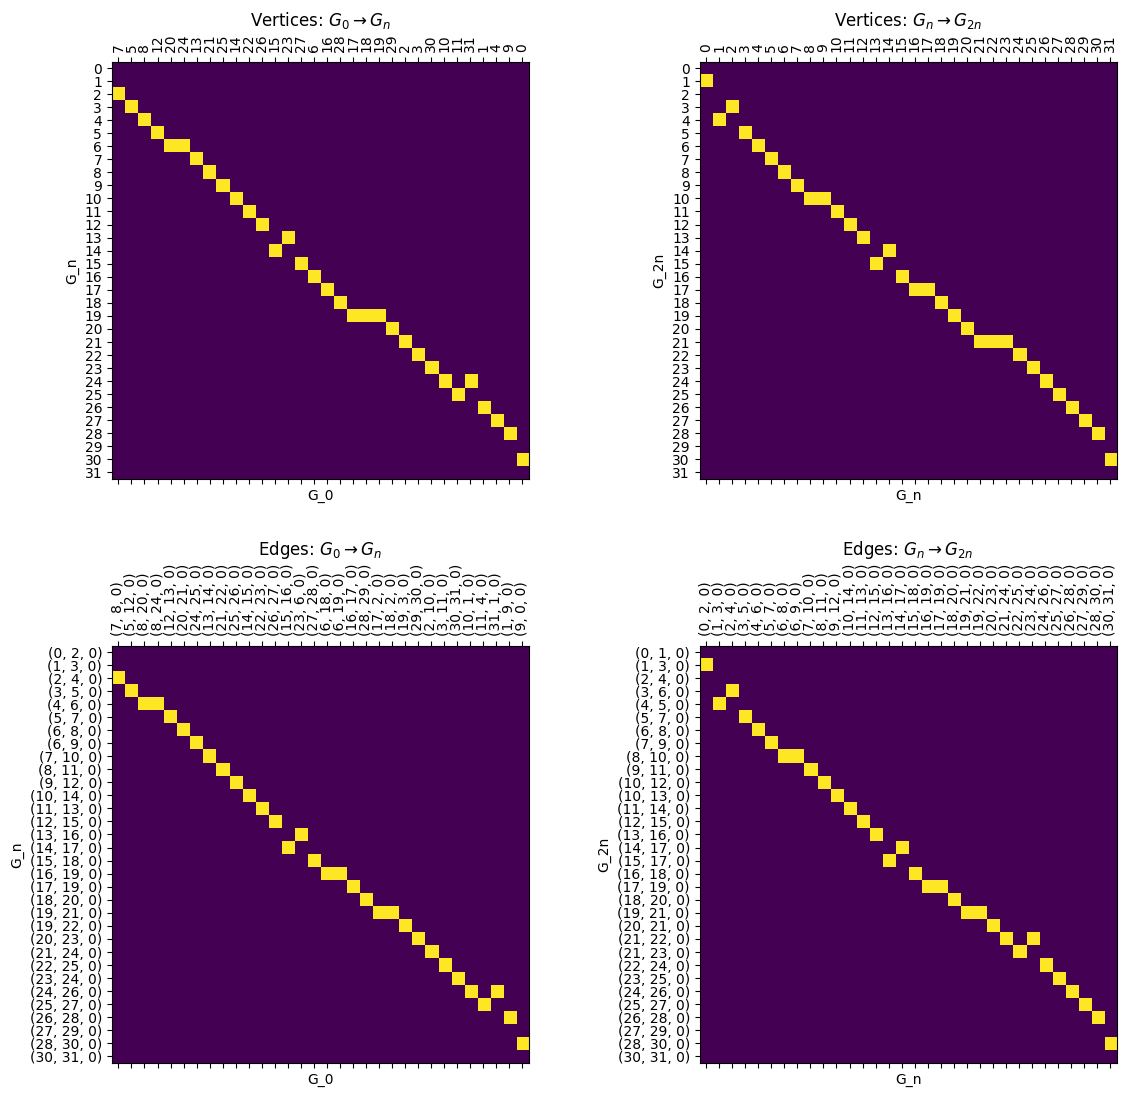

In [ ]:
myInt.draw_all_I()

### Boundary Matrices

We also have boundary matrices for each graph, where $B[v,e] = 1$ iff $v$ is a vertex of edge $e$.  Note that unlike the inclusion matrices, we don't have separate vertex and edge versions, and we don't have the nice block structure,  so this can be found as follows.

<Axes: >

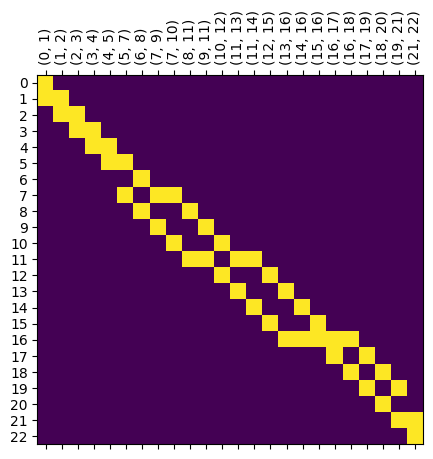

In [ ]:
myInt.B('F','n').draw()

We also have a drawing command, `Interleave.draw_B` to simplify the process, and `Interleave.draw_all_B` to show them all at once.

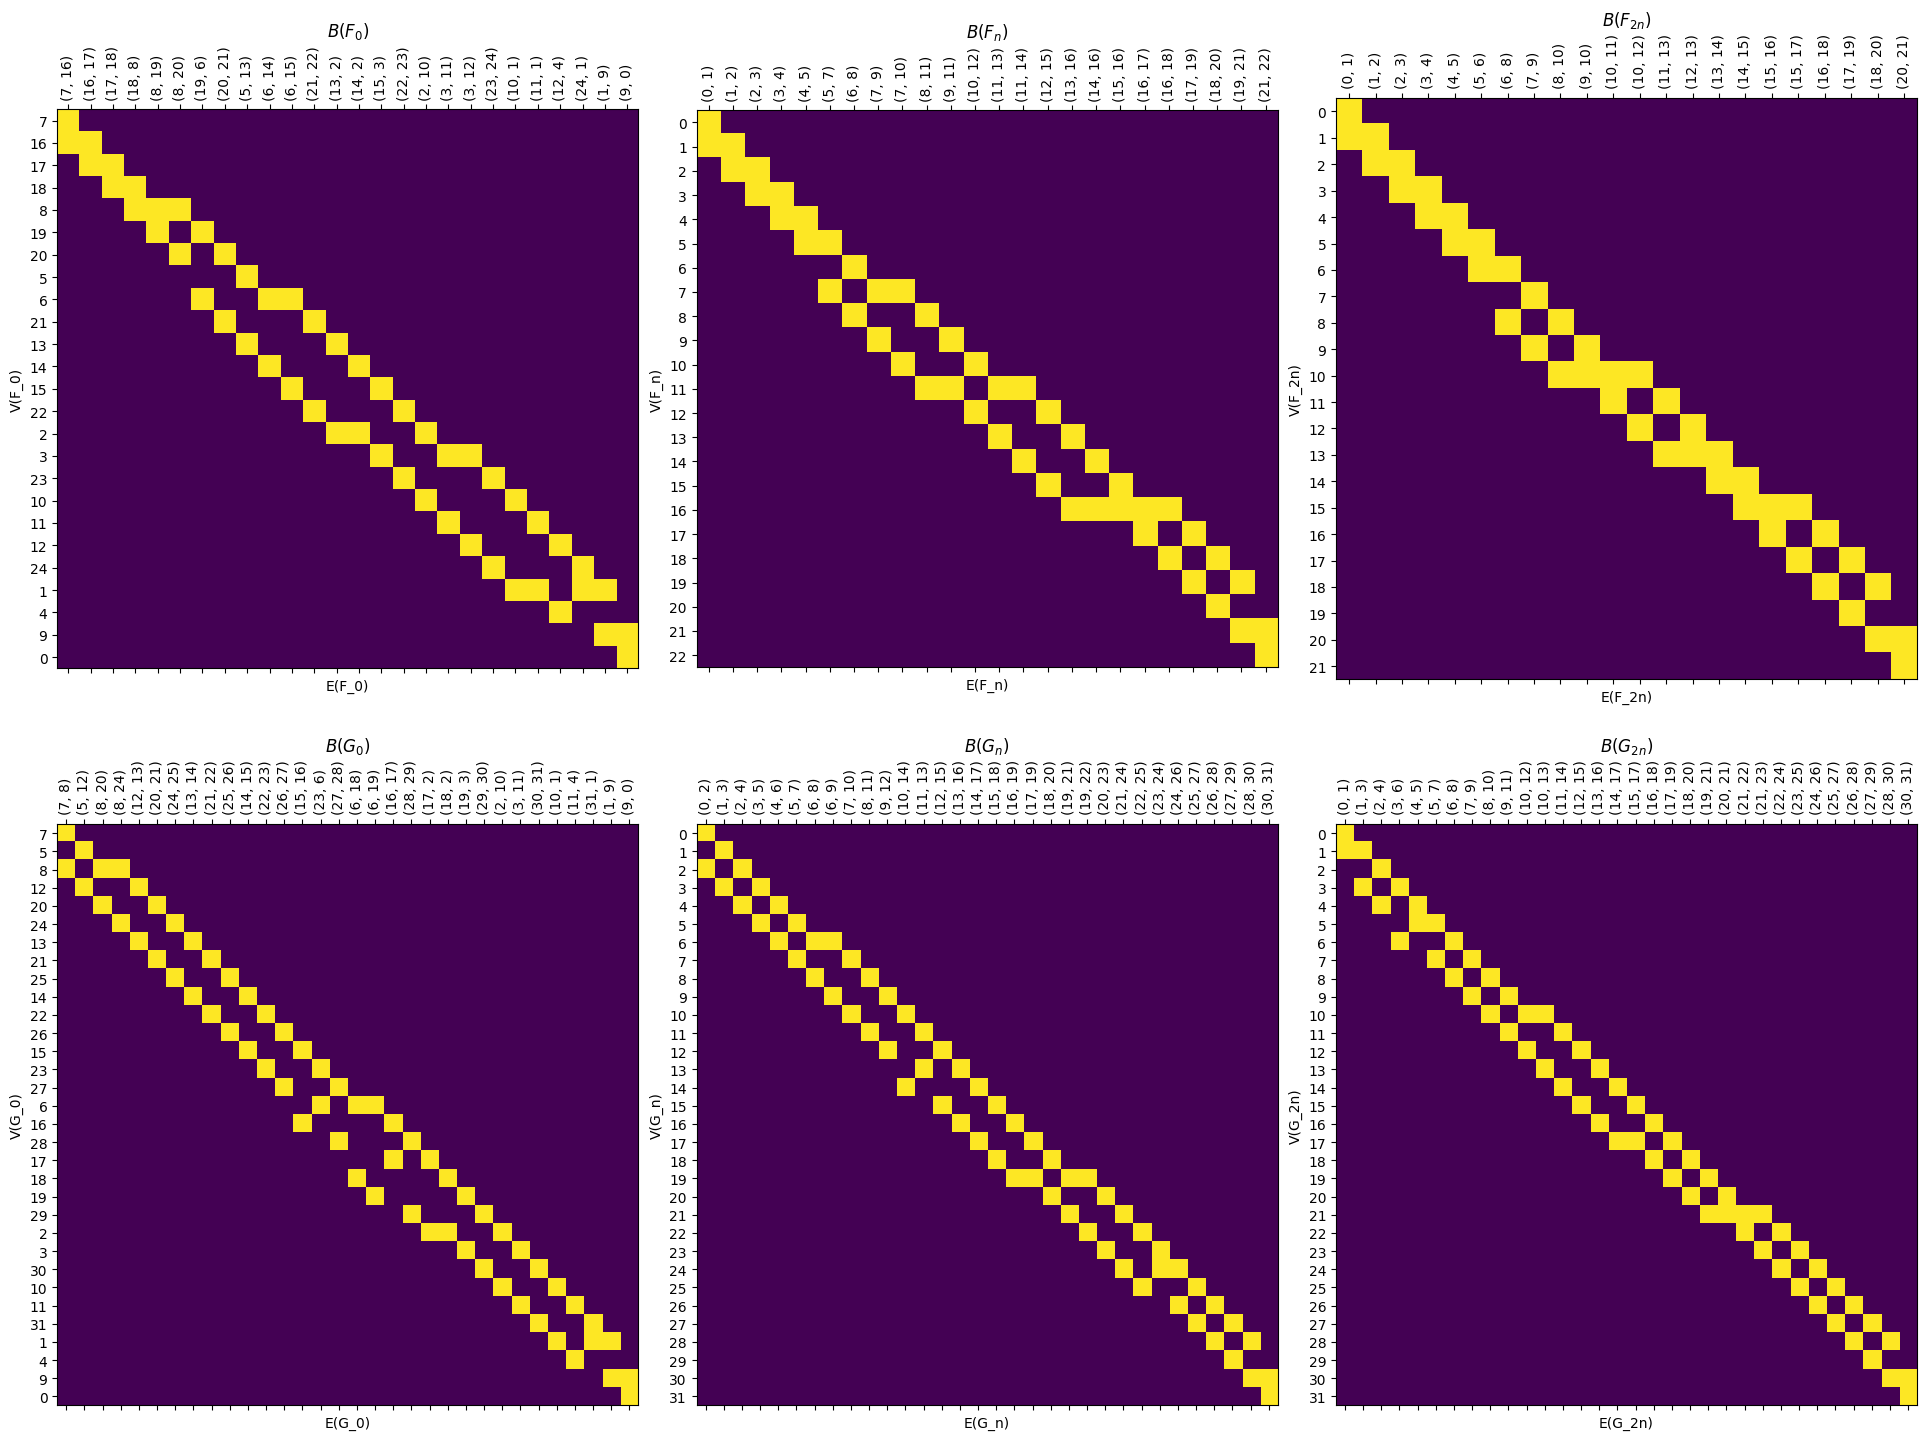

In [ ]:
myInt.draw_all_B()

### Distance matrix 

Following (our arXiv paper that we should cite), there is a distance between any vertices at the same level defined to be the amount of smoothing needed for the two vertices to be mapped to the same vertex. This block matrix is stored in `Interleave.D`. 

In [ ]:
# Here's the distance between the vertices at function value 9 in $F$
print(myInt.D('F','0','V')[9])

LabeledMatrix(
array=
[[0. 1. 1. 3.]
 [1. 0. 1. 3.]
 [1. 1. 0. 3.]
 [3. 3. 3. 0.]], 
rows=[13, 14, 15, 22], 
cols=[13, 14, 15, 22])


Text(0.5, 1.0, 'Distance Matrix for Vertices with Function Value 9 in $F$')

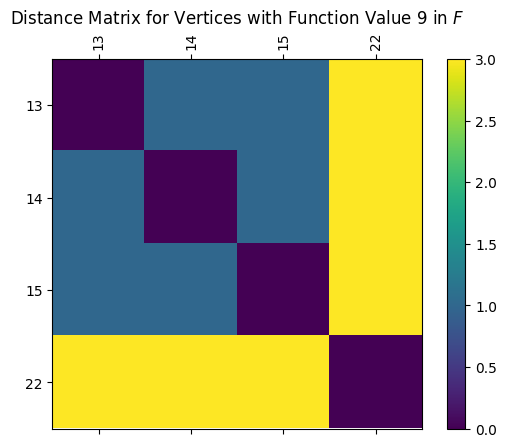

In [ ]:
# and here's a visual for the same distance matrix
myInt.D('F','0','V')[9].draw(colorbar=True)
plt.title(r'Distance Matrix for Vertices with Function Value 9 in $F$')

As before, we can easily draw the full distance matrix using the `draw_D` command. Here's the full matrix for $G_{n}$.

<Axes: xlabel='V(G_n)', ylabel='V(G_n)'>

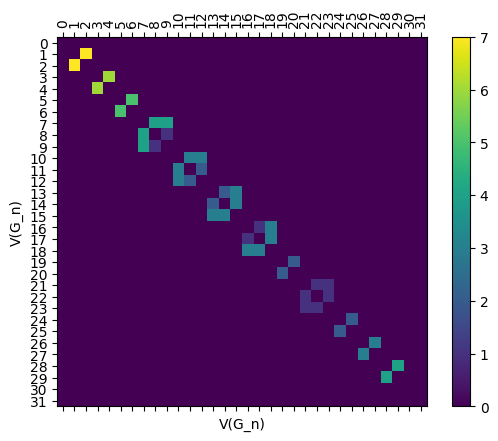

In [ ]:
myInt.draw_D('G', 'n','V')

And here's how we can have just the blocks showing up. 

<class 'numpy.ndarray'>


<Axes: xlabel='V(G_n)', ylabel='V(G_n)'>

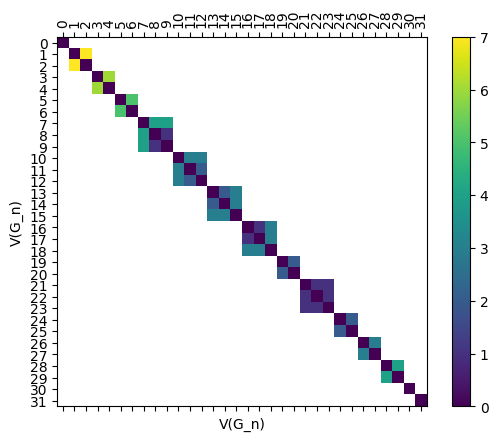

In [ ]:
myInt.draw_D('G', 'n','V', filltype = 'nan')

Here's an edge version too. 

TODO: This needs to be checked because I think there's something funny with indexing? This whole thing needs testing in any case. 

<class 'numpy.ndarray'>


<Axes: xlabel='V(G_n)', ylabel='V(G_n)'>

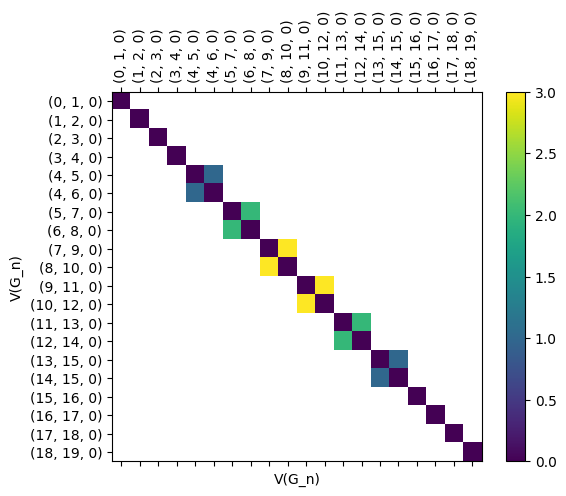

In [ ]:
myInt.draw_D('G', 'n','E', filltype = 'nan')

## Initializing a random interleaving 

Let's go back to a simpler example for a while. We'll compare the distance between a torus and a line graph. 

In [ ]:
T = ex_mg.torus(0, 2, 10, 12, delta = 1, seed = 17)
L = ex_mg.line(0, 12)

As before, we can intialize the interleaving. This time, however, we ask for randomly generated maps $\varphi: F \to G^n$ and $\psi: G \to F^n$. 

In [ ]:
myInt = Interleave(L,T, initialize_random_maps = True, seed = 0)

Let's draw all the relevant graphs just to be able to look at what's going on here. 

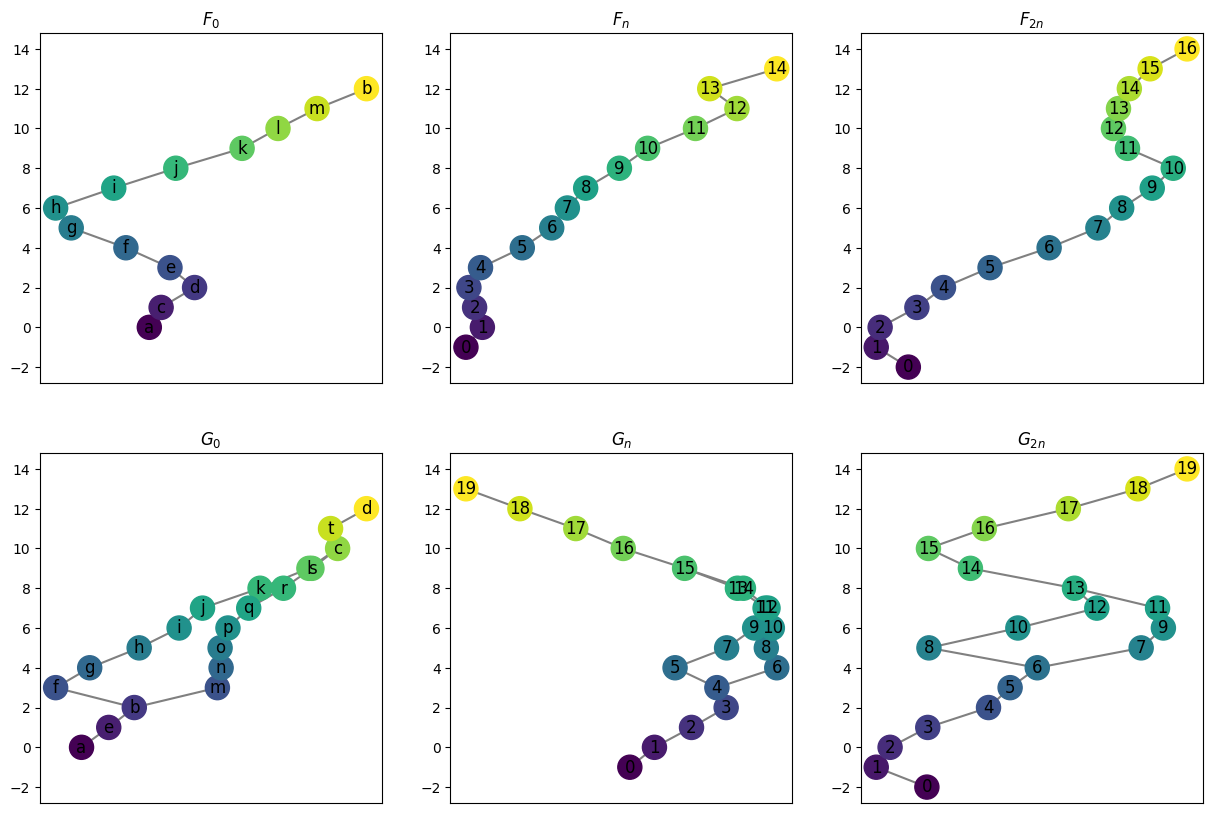

In [ ]:
myInt.draw_all_graphs()


These can be accessed using the `Interleave.phi` and `Interleave.psi` functions. As before, these are stored as `LabeledBlockMatrix` types. 

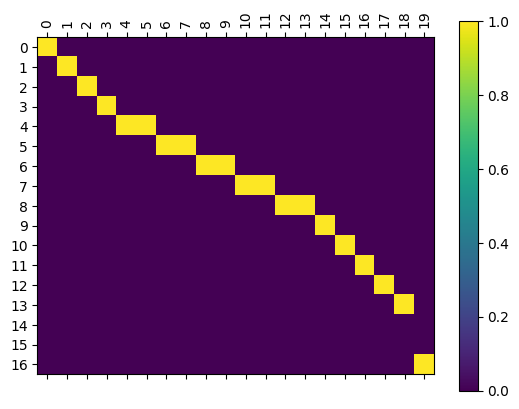

In [ ]:
myInt.psi('n','V').draw(colorbar = True)

<Axes: xlabel="<class 'type'>(F)", ylabel="<class 'type'>(G_n)">

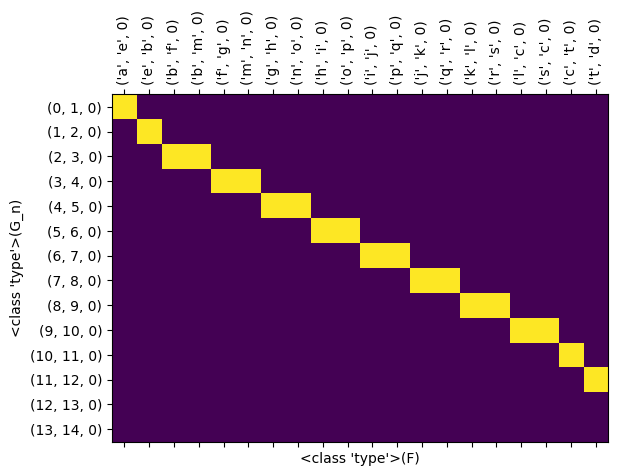

In [ ]:
myInt.draw_psi('0','E')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


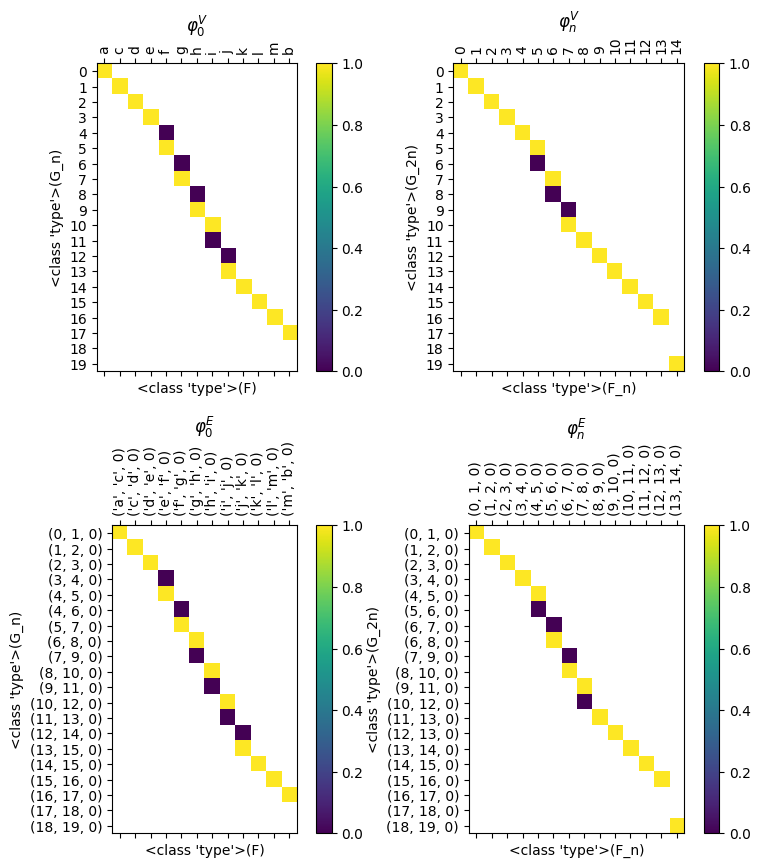

In [ ]:
myInt.draw_all_phi(filltype = 'nan', colorbar = True)

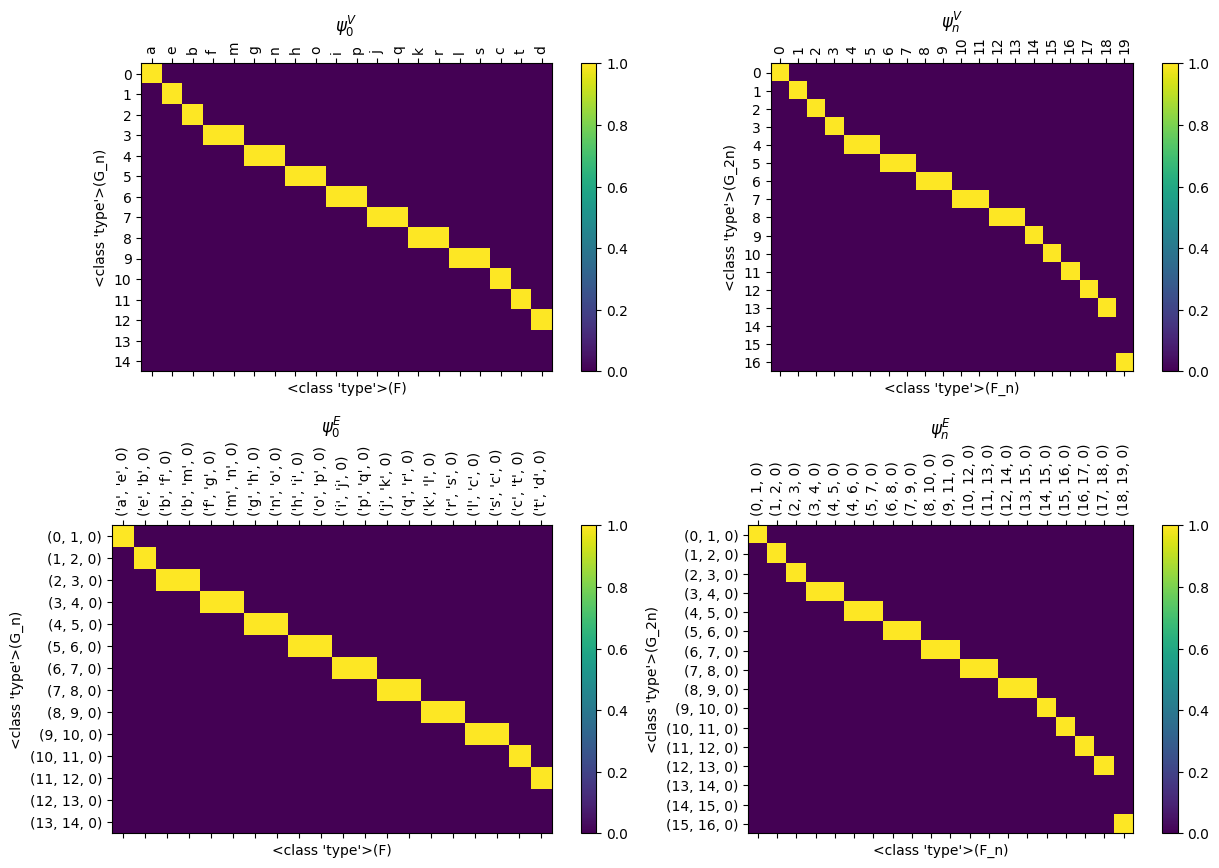

In [ ]:
myInt.draw_all_psi(figsize = (15,10), colorbar = True)

## Checking all the diagrams

We have a giant list of diagrams to check. However, these are now reduced to multiplying all these matrices we've built above. 

For instance, the diagram 

```
F(U_\tau)   --B_F--> F(U_\sigma)
   |                     |
  phi_E                phi_V
   |                     |
   V                     V
G(U_\tau^n) --B_G--> G(U_\sigma^n)
```

can be checked for commutativity by checking if this matrix multiplication is 0. 

Text(0.5, 1.0, '$\\varphi_{0,V} \\cdot B_F - B_G \\cdot \\varphi_{0,E}$')

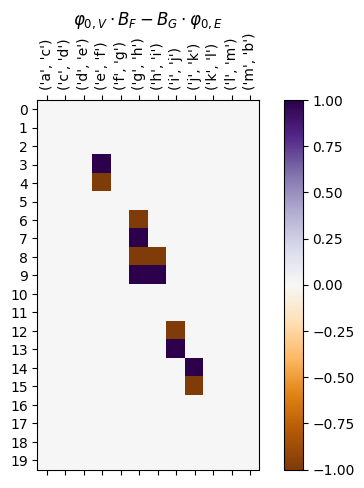

In [ ]:
Top = myInt.phi('0', 'V') @ myInt.B('F', '0')
Bottom = myInt.B('G', 'n') @ myInt.phi('0', 'E')

Diff = Top - Bottom
ax = Diff.draw(colorbar = True, cmap = 'PuOr')
ax.set_title(r'$\varphi_{0,V} \cdot B_F - B_G \cdot \varphi_{0,E}$')

# This is the same as 
# myInt.parallelogram_Edge_Vert('phi', returntype = 'commute', draw = True)

### Parallelograms - Edge vertex

The first shown example is the same one done with the `myInt.parallelogram_matrix_Edge_Vert` command. Note that we can either pass in `phi` or `psi` to get the relevant diagrams. The `draw = True` is helpful for debugging and visualization. 

Maximum absolute value in the parallelogram matrix: 3.0


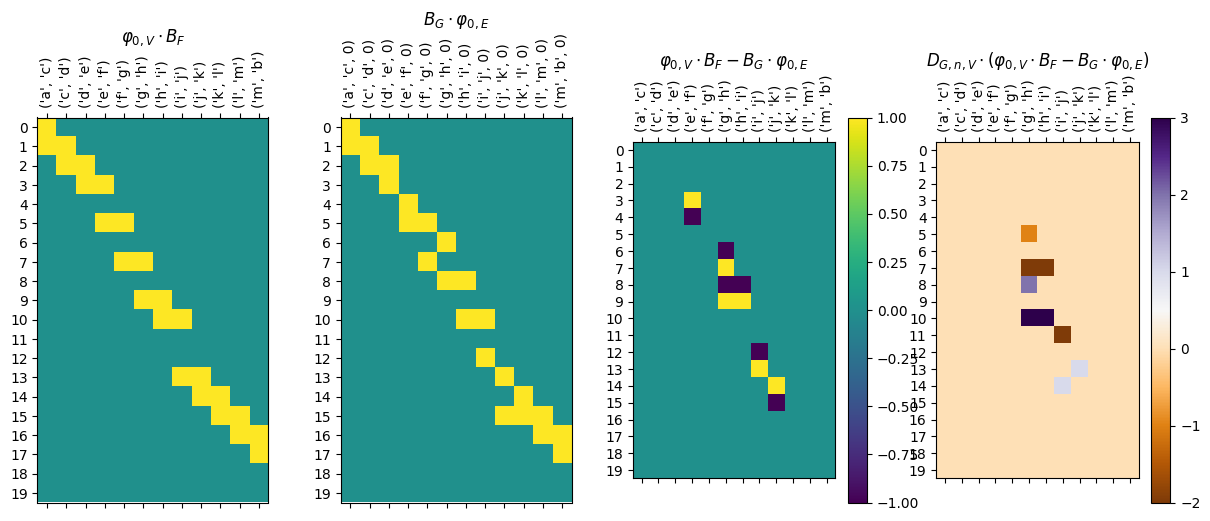

In [ ]:
Result = myInt.parallelogram_Edge_Vert('phi', draw = True)

print(f"Maximum absolute value in the parallelogram matrix: {Result.absmax()}")

Maximum absolute value in the parallelogram matrix: 0.0


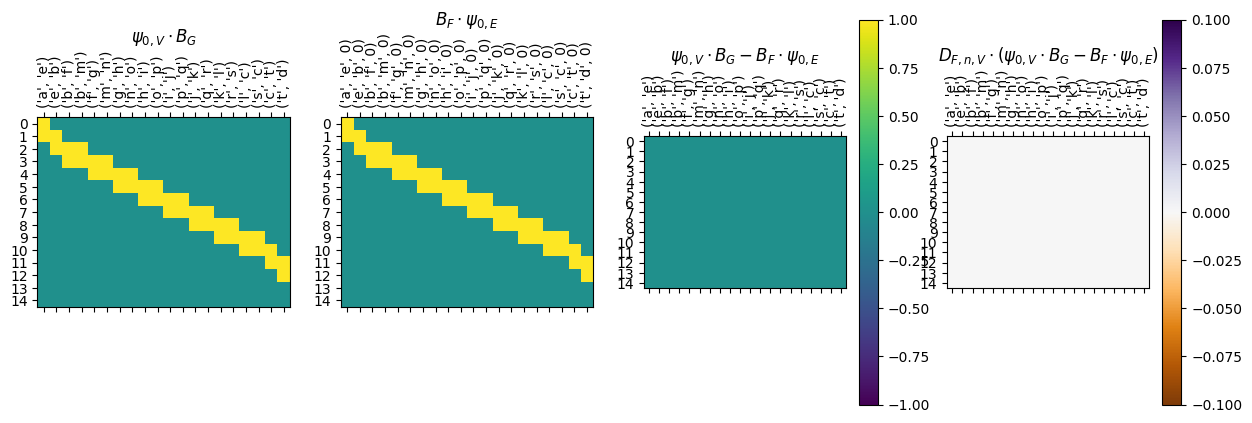

In [ ]:
Result = myInt.parallelogram_Edge_Vert('psi', draw = True)
print(f"Maximum absolute value in the parallelogram matrix: {Result.absmax()}")

### Parallelograms - Thickening 

These are the parallelograms that keep track of whether the maps from $U \to U^n$ form a natural transformation. 

Maximum absolute value in the parallelogram matrix: 2.0


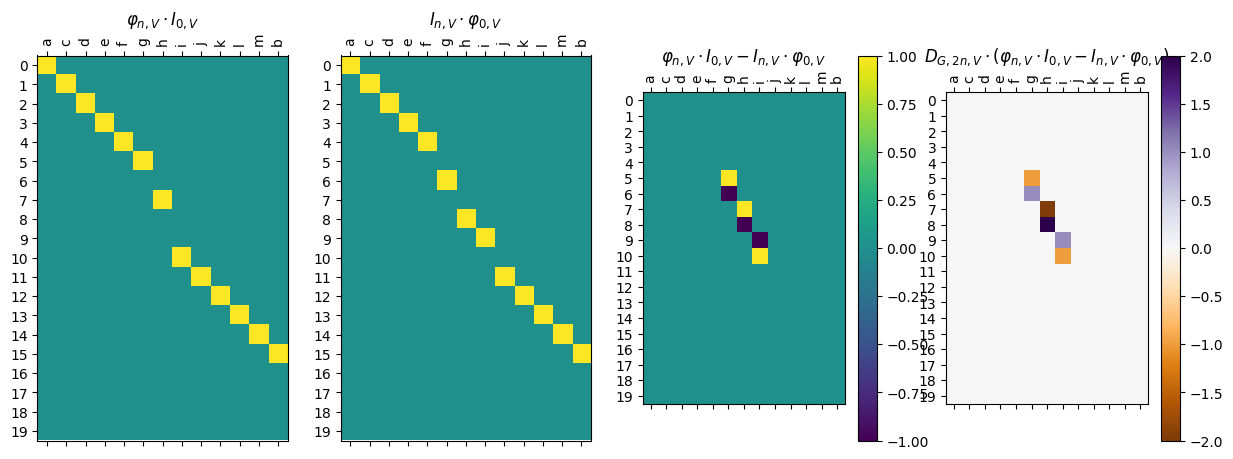

In [ ]:
Result = myInt.parallelogram('phi', 'V', returntype = 'dist', draw = True)
print(f"Maximum absolute value in the parallelogram matrix: {Result.absmax()}")

Maximum absolute value in the parallelogram matrix: 0.0


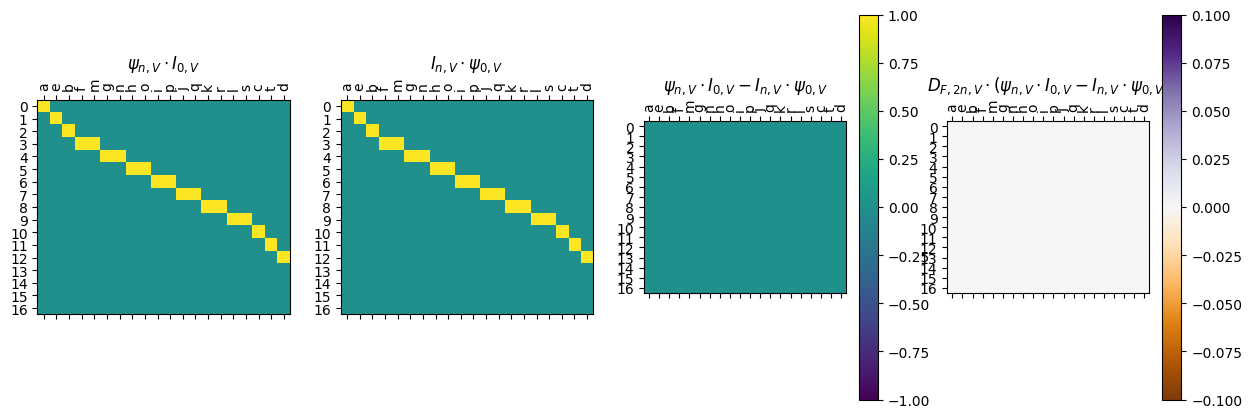

In [ ]:
Result = myInt.parallelogram('psi', 'V', returntype = 'dist', draw = True)
print(f"Maximum absolute value in the parallelogram matrix: {Result.absmax()}")

Maximum absolute value in the parallelogram matrix: 2.0


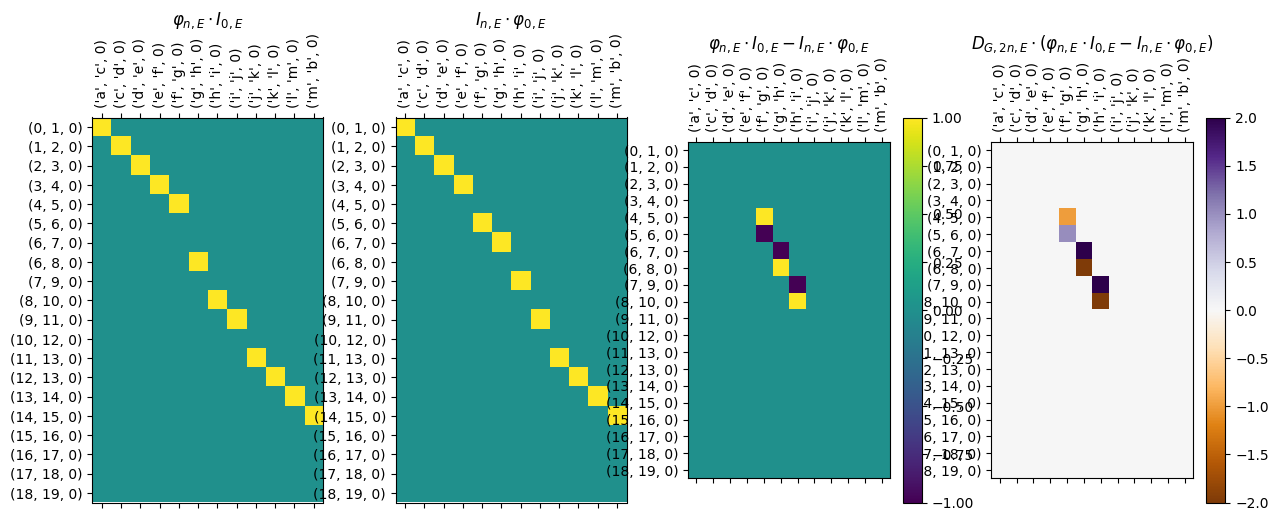

In [ ]:
Result = myInt.parallelogram('phi', 'E', returntype = 'dist', draw = True)
print(f"Maximum absolute value in the parallelogram matrix: {Result.absmax()}")

Maximum absolute value in the parallelogram matrix: 0.0


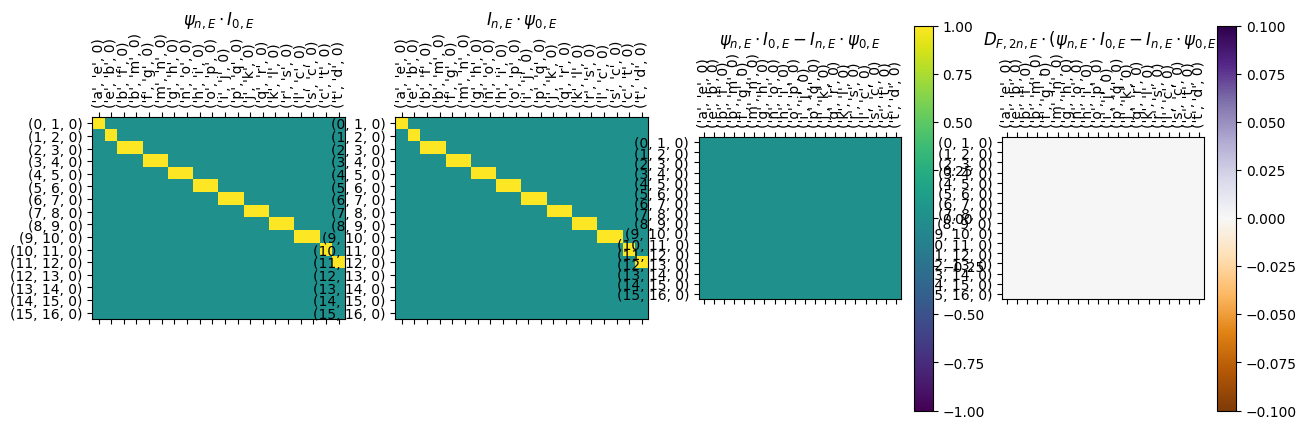

In [ ]:
Result = myInt.parallelogram('psi', 'E', returntype = 'dist', draw = True)
print(f"Maximum absolute value in the parallelogram matrix: {Result.absmax()}")

In [ ]:
k = myInt.loss()

print(f"Loss: {k}")
print(f"d_I(F,G) \leq {myInt.n + k}")

Loss: 3.0
d_I(F,G) \leq 4.0
